## Case Study: Stock Price Prediction 


<h4> The Case study is to predict Next day stock price [Adj Close Price] using  regression analysis</h4>
<p>
    We will be using Nifty 50 data for this case study<br>
    The filename '^NSEI.csv' contains the data<br>
    You need to generate  technical indicators as given below as  Features for converting Time Series to Supervised Learning Problem <br>
   <a href='https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/'> Convert time Series to Supervised Learning</a><p>
    <ul>
        <li> Moving Averages (Example Given : 3Period Moving Avearage (3MA)) </li>
        <li> Previous Day Returns </li>
        <li> Relative Stock returns </li>
    </ul>
<br>
Then you need to Train a Supervised learning algorithm and perform prediction.<br>
<a href='https://blog.quantinsti.com/random-forest-algorithm-in-python/'>Example for your Refrence </a><br>
<b> Make sure  to shift the feature by 1 period so that you will have data from t-1 period to predict price at t (look ahead bias) </b>

<strong> Please consider Testing Period after  01-01-2019 </strong>
</p>
<p>
    <b> Metrics for Evaluation </b>
    <ul>
        <li><strong> RMSE </strong></li>
     </ul>
</p>
<p> Some additional Documention for your help
    <ul>
        <li><a href='https://pandas.pydata.org/docs/'> Pandas Documentation </a> </li>
        <li><a href='https://scikit-learn.org/stable/'> Scikit Learn </a></li>
        </ul>
        </p>

#### Resolution

##### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as rmse #metric for model evaluation
import matplotlib.pyplot as plt
# %matplotlib inline

#Regression models used
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

##### Import the data and perform a preliminary exploration

In [2]:
# Reading the Stock 
df=pd.read_csv("^NSEI.csv")

In [3]:
# Getting the head of the data
df.head()

Date         Open         High          Low        Close  \
0  2007-09-17  4518.450195  4549.049805  4482.850098  4494.649902   
1  2007-09-18  4494.100098  4551.799805  4481.549805  4546.200195   
2  2007-09-19  4550.250000  4739.000000  4550.250000  4732.350098   
3  2007-09-20  4734.850098  4760.850098  4721.149902  4747.549805   
4  2007-09-21  4752.950195  4855.700195  4733.700195  4837.549805   

     Adj Close  Volume  
0  4494.649902     0.0  
1  4546.200195     0.0  
2  4732.350098     0.0  
3  4747.549805     0.0  
4  4837.549805     0.0

In [4]:
# Variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3071 non-null   object 
 1   Open       3039 non-null   float64
 2   High       3039 non-null   float64
 3   Low        3039 non-null   float64
 4   Close      3039 non-null   float64
 5   Adj Close  3039 non-null   float64
 6   Volume     3039 non-null   float64
dtypes: float64(6), object(1)
memory usage: 168.1+ KB


From the output above, we can see that we have some missing values. Let's take a deeper look at these:

In [5]:
null_data = df[df.isnull().any(axis=1)]

print('First nulls:')
display(null_data.head())

print('\n Last nulls:')
display(null_data.tail())

First nulls:


Date  Open  High  Low  Close  Adj Close  Volume
295  2008-11-27   NaN   NaN  NaN    NaN        NaN     NaN
393  2009-04-30   NaN   NaN  NaN    NaN        NaN     NaN
507  2009-10-13   NaN   NaN  NaN    NaN        NaN     NaN
556  2009-12-23   NaN   NaN  NaN    NaN        NaN     NaN
557  2009-12-24   NaN   NaN  NaN    NaN        NaN     NaN


 Last nulls:


Date  Open  High  Low  Close  Adj Close  Volume
2047  2016-01-01   NaN   NaN  NaN    NaN        NaN     NaN
2199  2016-08-12   NaN   NaN  NaN    NaN        NaN     NaN
2541  2018-01-01   NaN   NaN  NaN    NaN        NaN     NaN
2787  2019-01-01   NaN   NaN  NaN    NaN        NaN     NaN
2985  2019-10-27   NaN   NaN  NaN    NaN        NaN     NaN

The missing values correspond to holidays. Depending the modeling approach used, missing values may or may not be problematic, so we could decide to handle them later on in the modelling stage. Nevertheless, nulls can lead to unexpected values when defining the new variables (the technical indicators). For instance, October 27, 2019 was a Tuesday. The previous and the next values are available. If we wanted to consider the lagged value of Adj Close as an estimation, the prediction for October 28 would be NaN, but it would be reasonable to consider the value of October 26. 

This said, we are going to remove all missing values at this stage.

##### Data preparation

In [6]:
# Selecting Adj Close
df=df[['Date','Adj Close']]

In [7]:
# Removing missing values
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039 entries, 0 to 3070
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3039 non-null   object 
 1   Adj Close  3039 non-null   float64
dtypes: float64(1), object(1)
memory usage: 71.2+ KB


In [8]:
# Period covered
print('The earliest date is:', min(df['Date']))
print('The latest date is:', max(df['Date']))

The earliest date is: 2007-09-17
The latest date is: 2020-02-27


In [9]:
# We order the dataframe to make sure the time series is ordered
df=df.sort_values(by = 'Date')

We now define the technical indicators. We will consider:
* the 3 period moving average: predict the Adj Close value based on the average value of the last 3 periods
* the 3 period standard deviation: predict the Adj Close value based on the std of the last 3 periods
* the previous day returns predict the Adj Close value based on the previous value (1 lag)

In [10]:
# 3period moving average
df['3MA']=df['Adj Close'].rolling(3).mean()
### shifting Feature 3MA  so that features at t-1 will be used to predict close at t
df['3MA']=df['3MA'].shift(1) 

In [11]:
# 3period std
df['3_std']=df['Adj Close'].rolling(3).std()
df['3_std']=df['3_std'].shift(1) 

In [12]:
# Previous Day Returns
df['prev'] = df['Adj Close'].shift(1)

Note that we obtain some new missing values. We will remove the first three observations too.

In [13]:
print('Initial observations:')
display(df.head())

df=df.dropna()

Initial observations:


Date    Adj Close          3MA       3_std         prev
0  2007-09-17  4494.649902          NaN         NaN          NaN
1  2007-09-18  4546.200195          NaN         NaN  4494.649902
2  2007-09-19  4732.350098          NaN         NaN  4546.200195
3  2007-09-20  4747.549805  4591.066732  125.040395  4732.350098
4  2007-09-21  4837.549805  4675.366699  112.119343  4747.549805

We will split the dataset separating out observations after 2019-01-01 for model validation.

In [14]:
# Train Test Split  data (Make sure to consider the data is a time series data)
df_train = df[df.Date<='2019-01-01']
df_test = df[df.Date<'2019-01-01']

Lastly, we define the input and the output patterns. The idea is that the algorithm can learn how to predict the output patterns from the input patterns.

In [15]:
# X input
X_train = df_train[['3MA','3_std','prev']]
X_test = df_test[['3MA','3_std','prev']]


# Y output
y_train = df_train[['Adj Close']]
y_test = df_test[['Adj Close']]

##### Modelling: Random Forest

We will train random forest models, considering different maximum depths.

In [16]:
RF_2 = RandomForestRegressor(max_depth=2, random_state=0) #seed
RF_3 = RandomForestRegressor(max_depth=3, random_state=0) #seed

In [17]:
# Training
model_2 = RF_2.fit(X_train, np.ravel(y_train)) #ravel converts the data frame into an array of dimension 1
model_3 = RF_3.fit(X_train, np.ravel(y_train))

# Predict in the test sample
y_pred2 = model_2.predict(X_test)
y_pred3 = model_3.predict(X_test)

In [18]:
# Test performance of the model on the Testing Data using RMSE
print("Root Mean Squared Error (RMSE) using max depth 2: {}".format(rmse(y_test, y_pred2)))
print("Root Mean Squared Error (RMSE) using max depth 3: {}".format(rmse(y_test, y_pred3)))

Root Mean Squared Error (RMSE) using max depth 2: 250816.49148755602
Root Mean Squared Error (RMSE) using max depth 3: 62679.040444008926


We can also visually compare both estimations. The graph below plots both predictions against the actual value, for the test sample. 

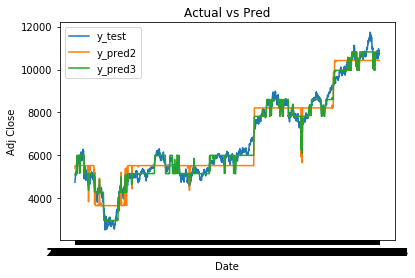

In [19]:
plt.plot(df_test['Date'],y_test, label="y_test")
plt.plot(df_test['Date'],y_pred2,label="y_pred2")
plt.plot(df_test['Date'],y_pred3,label="y_pred3")
plt.xlabel('Date') 
plt.ylabel('Adj Close') 
plt.title("Actual vs Pred") 
plt.legend()
plt.show()

The green prediction (using max_depth=3) is clearly a much better prediction. 



##### Modelling: Linear Regression

In [20]:
# We add a constant column for the intercept
X_train_ct = sm.add_constant(X_train)
X_test_ct = sm.add_constant(X_test)

# Training
reg_ols = sm.OLS(y_train, X_train_ct).fit()

# Summary of the model
results = reg_ols.summary()
display(results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.237e+05
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:20:39   Log-Likelihood:                -15837.
No. Observations:                2754   AIC:                         3.168e+04
Df Residuals:                    2750   BIC:                         3.171e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4042      5.311      0.641      0.522      -7.009      13.817
3MA           -0.0839      0.025     -3.381      0.001      -0.133      -0.035
3_std          0.0027      0.039      0.068      0.946      -0.075       0.080
prev           1.0837      0.025     43.680      0.000       1.035       1.132
==============================================================================
Omnibus:                      259.724   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1838.916
Skew:                          -0.057   Prob(JB):                         0.00
Kurtosis:                       7.002   Cond. No.                     3.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that that not all variables are statistically significant. We start my removing "3_Std" and/or the intercept.

In [21]:
## With no intercept (and three variables)

# Training
reg_ols = sm.OLS(y_train, X_train).fit()

# Summary of the model
results = reg_ols.summary()
display(results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.964e+06
Date:                Tue, 15 Sep 2020   Prob (F-statistic):                        0.00
Time:                        20:20:40   Log-Likelihood:                         -15838.
No. Observations:                2754   AIC:                                  3.168e+04
Df Residuals:                    2751   BIC:                                  3.170e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
3MA           -0.0839      0.025     -3.379      0.001      -0.133      -0.035
3_std          0.0133      0.036      0.374      0.708      -0.057       0.083
prev           1.0841      0.025     43.707      0.000       1.035       1.133
==============================================================================
Omnibus:                      261.137   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1861.171
Skew:                          -0.059   Prob(JB):                         0.00
Kurtosis:                       7.026   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# With intercept and no '3_std'

# X input
X_train = df_train[['3MA','prev']]
X_test = df_test[['3MA','prev']]

# We add a constant column for the intercept
X_train_ct = sm.add_constant(X_train)
X_test_ct = sm.add_constant(X_test)

# Training
reg_ols = sm.OLS(y_train, X_train_ct).fit()

# Summary of the model
results = reg_ols.summary()
display(results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.086e+06
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:20:40   Log-Likelihood:                -15837.
No. Observations:                2754   AIC:                         3.168e+04
Df Residuals:                    2751   BIC:                         3.170e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5563      4.811      0.739      0.460      -5.877      12.990
3MA           -0.0839      0.025     -3.383      0.001      -0.132      -0.035
prev           1.0836      0.025     43.744      0.000       1.035       1.132
==============================================================================
Omnibus:                      259.569   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1837.333
Skew:                          -0.056   Prob(JB):                         0.00
Kurtosis:                       7.000   Cond. No.                     3.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# No intercept and removing '3_std'

# Training
reg_ols = sm.OLS(y_train, X_train).fit()

# Summary of the model
results = reg_ols.summary()
display(results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.195e+07
Date:                Tue, 15 Sep 2020   Prob (F-statistic):                        0.00
Time:                        20:20:40   Log-Likelihood:                         -15838.
No. Observations:                2754   AIC:                                  3.168e+04
Df Residuals:                    2752   BIC:                                  3.169e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
3MA           -0.0834      0.025     -3.364      0.001      -0.132      -0.035
prev           1.0836      0.025     43.747      0.000       1.035       1.132
==============================================================================
Omnibus:                      260.577   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1857.455
Skew:                          -0.052   Prob(JB):                         0.00
Kurtosis:                       7.022   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the last case we obtain that both independent variables are statistically significant. We choose this option, to predict the values in the test sample. 

In [24]:
# Predict in the test sample
y_pred_ols = reg_ols.predict(X_test)

Let's calculate RMSE and compare all the models.

In [25]:
# Test performance of the model on the Testing Data using RMSE
print("Root Mean Squared Error (RMSE) using linear regression: {}".format(rmse(y_test, y_pred_ols)))

print('\n Recall the values obtained using Random Forest:')
print("Root Mean Squared Error (RMSE) using max depth 2: {}".format(rmse(y_test, y_pred2)))
print("Root Mean Squared Error (RMSE) using max depth 3: {}".format(rmse(y_test, y_pred3)))

Root Mean Squared Error (RMSE) using linear regression: 5788.952317723273

 Recall the values obtained using Random Forest:
Root Mean Squared Error (RMSE) using max depth 2: 250816.49148755602
Root Mean Squared Error (RMSE) using max depth 3: 62679.040444008926


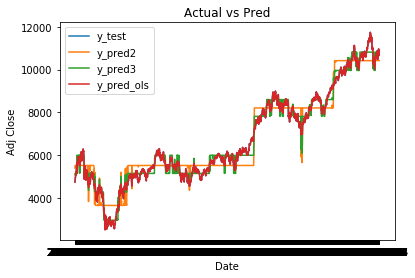

In [26]:
plt.plot(df_test['Date'],y_test, label="y_test")
plt.plot(df_test['Date'],y_pred2,label="y_pred2")
plt.plot(df_test['Date'],y_pred3,label="y_pred3")
plt.plot(df_test['Date'],y_pred_ols,label="y_pred_ols")
plt.xlabel('Date') 
plt.ylabel('Adj Close') 
plt.title("Actual vs Pred") 
plt.legend()
plt.show()

##### Conclusions

The linear regression, with the selected features, seems to be the best model. Nevertheless, it is worth mentioning that the random forest function has several parameters to set, one of which is the maximum depth of the individual trees. Though increasing the maximum depth may seem like an obvious way of improving the model, it may also lead to overfitting. In this case, we see that the RMSE in the test sample is much smaller using max_depth =3 and that the model fits de data better too, based on the figure.
The best approach would be to consider a mesh for different values of different parameters and train a model for each combination, compare them and select the best one. 